## ADSP 32009 - Data Science in Healthcare (Autumn 23)

### Final Project - Health Insurance Claim Prediction

#### Mariam Adeyemo
#### Minh Vo

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import joblib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
claim_df = pd.read_csv("/content/drive/My Drive/DSHC-Final-Project/health_insurance.csv")
claim_df.head()

,age,sex,weight,bmi,hereditary_diseases,no_of_dependents,smoker,city,bloodpressure,diabetes,regular_ex,job_title,claim
0,60.0,male,64,24.3,NoDisease,1,0,NewYork,72,0,0,Actor,13112.6
1,49.0,female,75,22.6,NoDisease,1,0,Boston,78,1,1,Engineer,9567.0
2,32.0,female,64,17.8,Epilepsy,2,1,Phildelphia,88,1,1,Academician,32734.2
3,61.0,female,53,36.4,NoDisease,1,1,Pittsburg,72,1,0,Chef,48517.6
4,19.0,female,50,20.6,NoDisease,0,0,Buffalo,82,1,0,HomeMakers,1731.7


In [ ]:
#Check the information of the claim data to identify missing values in each column
claim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  14604 non-null  float64
 1   sex                  15000 non-null  object 
 2   weight               15000 non-null  int64  
 3   bmi                  14044 non-null  float64
 4   hereditary_diseases  15000 non-null  object 
 5   no_of_dependents     15000 non-null  int64  
 6   smoker               15000 non-null  int64  
 7   city                 15000 non-null  object 
 8   bloodpressure        15000 non-null  int64  
 9   diabetes             15000 non-null  int64  
 10  regular_ex           15000 non-null  int64  
 11  job_title            15000 non-null  object 
 12  claim                15000 non-null  float64
dtypes: float64(3), int64(6), object(4)
memory usage: 1.5+ MB


In [ ]:
#Check for duplicates
duplicates = claim_df.duplicated()

num_duplicates = duplicates.sum()

print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 1096


In [ ]:
# Drop the duplicates
claim_df.drop_duplicates(inplace=True)
claim_df.shape

(13904, 13)

In [ ]:
#calculating the percentage of missing values in each column
missing_values = claim_df.isnull().sum()
missing_values_percent = (missing_values / claim_df.shape[0]) * 100
print(missing_values_percent)

age                    2.596375
sex                    0.000000
weight                 0.000000
bmi                    6.480150
hereditary_diseases    0.000000
no_of_dependents       0.000000
smoker                 0.000000
city                   0.000000
bloodpressure          0.000000
diabetes               0.000000
regular_ex             0.000000
job_title              0.000000
claim                  0.000000
dtype: float64


### EDA

#### Handling Missing Values and Dropping Unwanted Columns


There are just two columns (age and bmi) with some missing values. We will try out some couple of methods to input the missing values by using the statistical distribution and density plot as a guide.

<Axes: xlabel='age', ylabel='Density'>

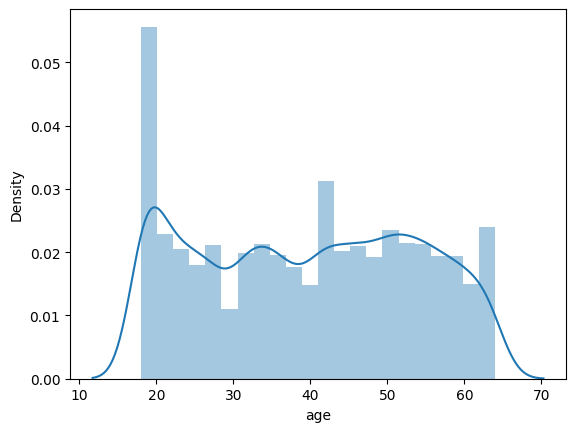

In [ ]:
#checking the distribution of the age column
sns.distplot(claim_df[claim_df['age'].notnull()]['age'])

In [ ]:
claim_df['age'].describe()

count    13543.000000
mean        39.556598
std         14.011047
min         18.000000
25%         27.000000
50%         40.000000
75%         52.000000
max         64.000000
Name: age, dtype: float64

Since the distribution of the age doesn't look like a normal distribution, we will use the interpolation method to impute the missing value so as not to change the distribution.

In [ ]:
#using the interpolate method to input the missing value
claim_df['age'] = claim_df['age'].interpolate()

In [ ]:
claim_df['age'].describe()

count    13904.000000
mean        39.552503
std         13.920992
min         18.000000
25%         27.000000
50%         40.000000
75%         51.000000
max         64.000000
Name: age, dtype: float64

The age statistics did not really deviate from the previous one before imputation.

<Axes: xlabel='bmi', ylabel='Density'>

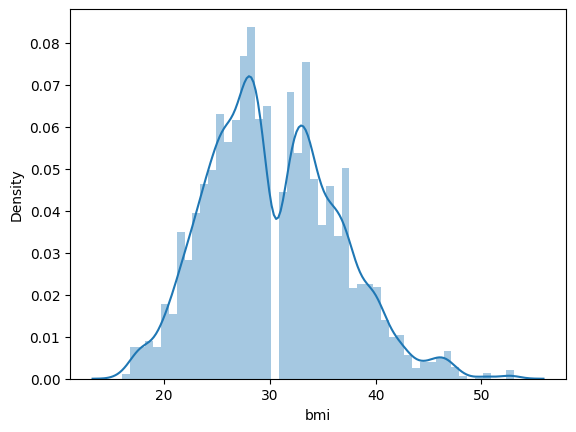

In [ ]:
#checking the distribution of the bmi column
sns.distplot(claim_df[claim_df['bmi'].notnull()]['bmi'])

In [ ]:
claim_df['bmi'].describe()

count    13003.000000
mean        30.273483
std          6.125247
min         16.000000
25%         25.700000
50%         29.400000
75%         34.400000
max         53.100000
Name: bmi, dtype: float64

For the bmi column, the distribution looks like a normal distribution. Though, there seem to be a gap around the mean of the distribution

Since it looks normally distributed, the mean will be used to impute the missing values

In [ ]:
# Calculate the mean of the BMI variable
mean_bmi = claim_df['bmi'].mean()

# Impute missing values with the mean
claim_df['bmi'].fillna(mean_bmi, inplace=True)

<Axes: xlabel='bmi', ylabel='Count'>

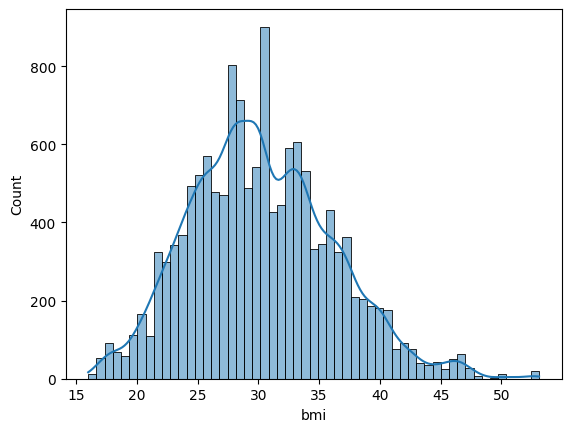

In [ ]:
sns.histplot(claim_df["bmi"], kde = True)

In [ ]:
claim_df['bmi'].describe()

count    13904.000000
mean        30.273483
std          5.923446
min         16.000000
25%         25.900000
50%         29.900000
75%         34.100000
max         53.100000
Name: bmi, dtype: float64

The bmi statistics did not really deviate from the previous one before imputation.

In [ ]:
claim_df.describe()

,age,weight,bmi,no_of_dependents,smoker,bloodpressure,diabetes,regular_ex,claim
count,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000
mean,39.552503,64.894347,30.273483,1.126438,0.200662,68.657652,0.771145,0.230725,13431.813744
std,13.920992,13.675070,5.923446,1.225661,0.400510,19.430514,0.420111,0.421312,12142.099413
min,18.000000,34.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1121.900000
25%,27.000000,54.000000,25.900000,0.000000,0.000000,64.000000,1.000000,0.000000,4883.900000
50%,40.000000,63.000000,29.900000,1.000000,0.000000,71.000000,1.000000,0.000000,9567.000000
75%,51.000000,76.000000,34.100000,2.000000,0.000000,80.000000,1.000000,0.000000,16657.700000
max,64.000000,95.000000,53.100000,5.000000,1.000000,122.000000,1.000000,1.000000,63770.400000


#### Check for the number of unique values in the categorical columns

Hereditary Diseases

In [ ]:
claim_df.columns

Index(['age', 'sex', 'weight', 'bmi', 'hereditary_diseases',
       'no_of_dependents', 'smoker', 'city', 'bloodpressure', 'diabetes',
       'regular_ex', 'job_title', 'claim'],
      dtype='object')

In [ ]:
len(claim_df['hereditary_diseases'].unique())

10

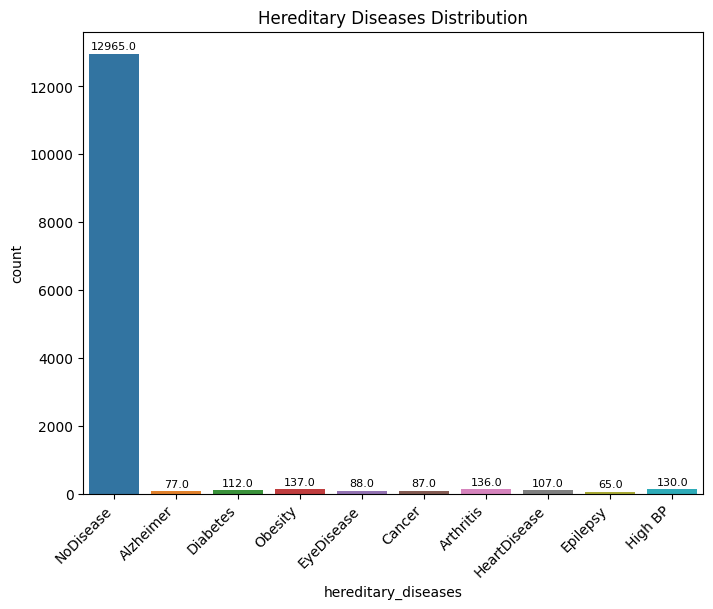

In [ ]:
hd_count = claim_df['hereditary_diseases'].value_counts()

# Create a countplot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='hereditary_diseases', data=claim_df)
plt.title('Hereditary Diseases Distribution')

# Add text labels above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Customize x-axis labels rotation and alignment
labels = hd_count.index
ax.set_xticklabels(labels, rotation=45, ha='right')

plt.show()

Most of the individuals don't have any hereditary disease

City

In [ ]:
len(claim_df['city'].unique())

91

In [ ]:
claim_df['city'].value_counts()

Nashville     270
Memphis       269
NewOrleans    268
Charleston    267
Brimingham    266
             ... 
York           68
Warwick        67
Syracuse       67
Baltimore      67
Trenton        66
Name: city, Length: 91, dtype: int64

Job Title

In [ ]:
len(claim_df['job_title'].unique())

35

In [ ]:
claim_df['job_title'].value_counts()

Student              1220
HomeMakers            899
Singer                697
FilmMaker             675
Actor                 662
Dancer                645
HouseKeeper           622
Manager               565
Police                381
Photographer          370
Beautician            363
Engineer              346
FashionDesigner       346
Clerks                345
Accountant            345
CEO                   344
Architect             337
Politician            333
ITProfessional        326
DataScientist         304
Lawyer                289
Academician           287
Doctor                283
DefencePersonnels     266
Blogger               262
Chef                  257
Journalist            255
FilmDirector          255
Technician            253
CA                    250
Analyst               239
Farmer                235
GovEmployee           232
Buisnessman           224
Labourer              192
Name: job_title, dtype: int64

Sex

In [ ]:
len(claim_df['sex'].unique())

2

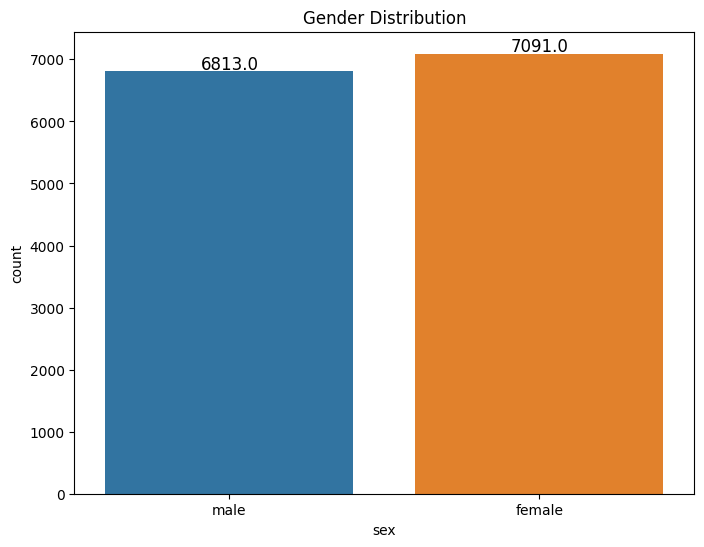

In [ ]:
# Create a countplot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='sex', data=claim_df)
plt.title('Gender Distribution')

# Add text labels above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

There are slightly more females compared to males

Diabetes

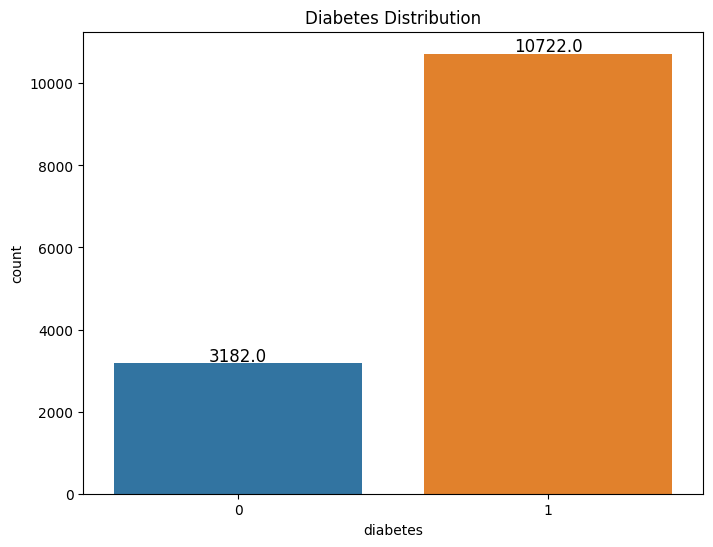

In [ ]:
# Create a countplot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='diabetes', data=claim_df)
plt.title('Diabetes Distribution')

# Add text labels above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

The majority of the population is affected by diabetes

Smokers

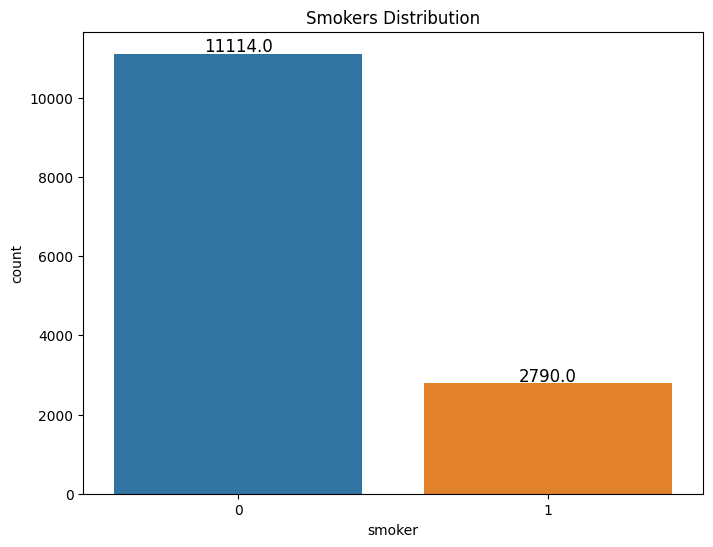

In [ ]:
# Create a countplot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='smoker', data=claim_df)
plt.title('Smokers Distribution')

# Add text labels above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

Majority of the population are non-smokers

Regular Exercise

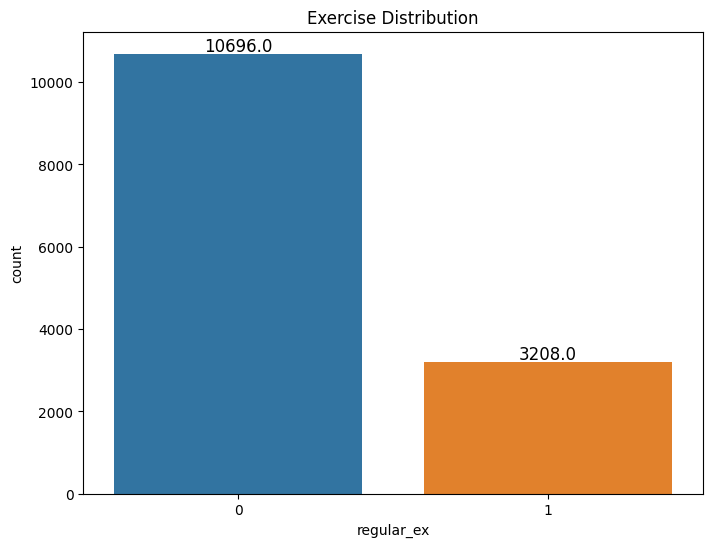

In [ ]:
# Create a countplot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='regular_ex', data=claim_df)
plt.title('Exercise Distribution')

# Add text labels above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

Majority of the population are not exercising regularly

Number of Children

In [ ]:
len(claim_df['no_of_dependents'].unique())

6

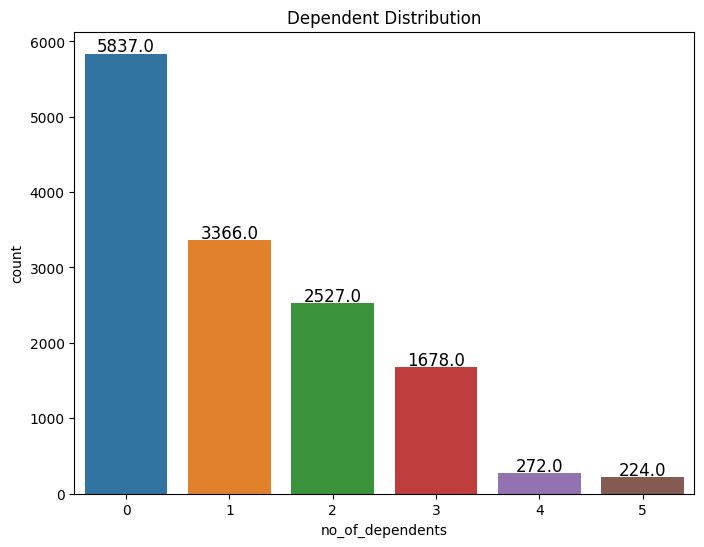

In [ ]:
# Create a countplot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='no_of_dependents', data=claim_df)
plt.title('Dependent Distribution')

# Add text labels above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

Majority of the population do not have any child

Claim

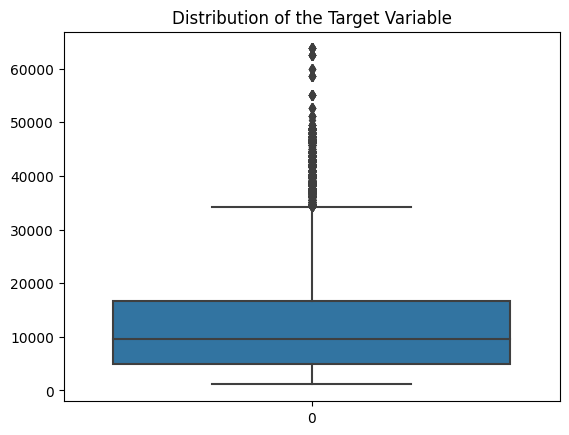

In [ ]:
sns.boxplot(claim_df.claim)
plt.title('Distribution of the Target Variable')
plt.show()

<Axes: xlabel='claim', ylabel='Count'>

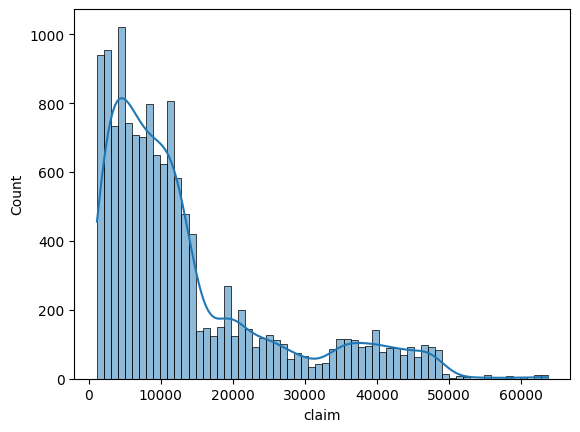

In [ ]:
sns.histplot(claim_df["claim"], kde = True)

There are outliers in the claim variable and it doesn't follow a normal distribution

#### Univariate Analysis

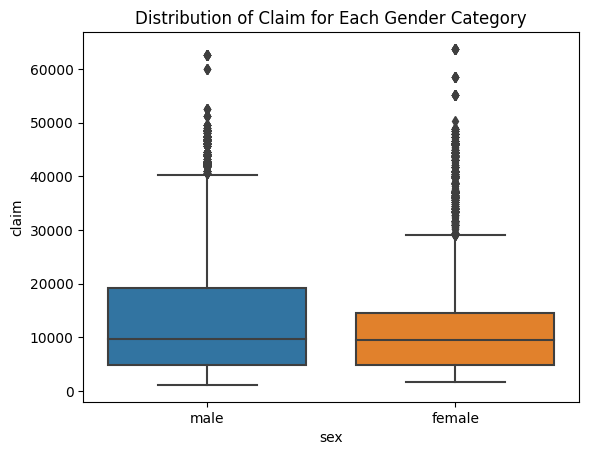

In [ ]:
#checking the distribution of claim for each gender category
sns.boxplot(x='sex', y='claim', data=claim_df)
plt.title('Distribution of Claim for Each Gender Category')
plt.show()

In [ ]:
summary_stats = claim_df.groupby('sex')['claim'].describe()

# Display the summary statistics
print(summary_stats)

         count          mean           std     min     25%     50%      75%  \
sex                                                                           
female  7091.0  12748.322000  11322.934398  1607.5  4883.9  9541.7  14571.9   
male    6813.0  14143.194921  12902.169164  1121.9  4878.0  9617.7  19199.9   

            max  
sex              
female  63770.4  
male    62592.9  


Male tend to have more mean claim amounts compared to female. It is also interesting to note that there are presence of outliers for both genders

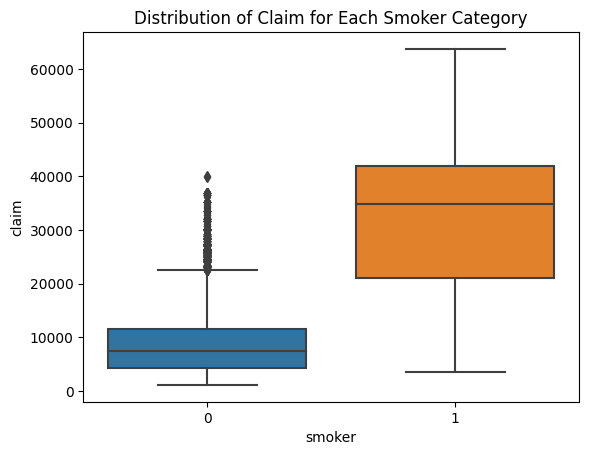

In [ ]:
#checking the distribution of claim for each smoker category
sns.boxplot(x='smoker', y='claim', data=claim_df)
plt.title('Distribution of Claim for Each Smoker Category')
plt.show()

In [ ]:
summary_stats = claim_df.groupby('smoker')['claim'].describe()

# Display the summary statistics
print(summary_stats)

          count          mean           std     min      25%      50%  \
smoker                                                                  
0       11114.0   8745.036513   6237.701515  1121.9   4243.6   7512.3   
1        2790.0  32101.649642  11986.510337  3480.8  20984.1  34779.6   

            75%      max  
smoker                    
0       11534.9  40114.8  
1       41999.5  63770.4  


Smokers have a high claim amount compared to non-smokers

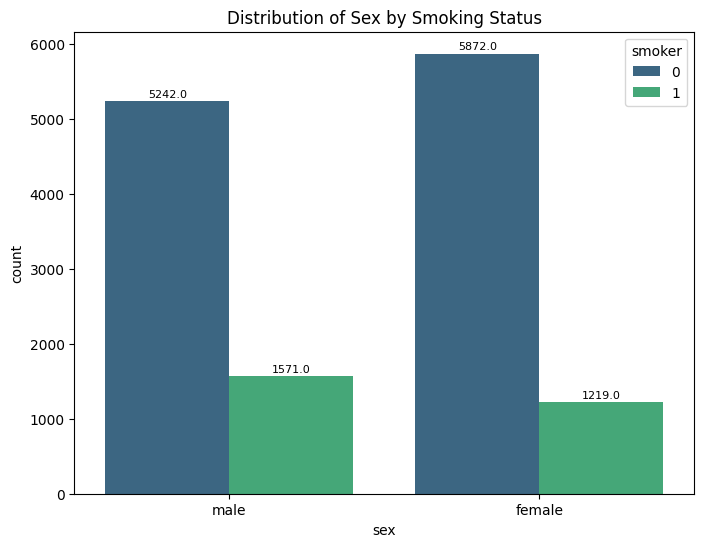

In [ ]:
# Create a countplot with hue
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='sex', hue='smoker', data=claim_df, palette='viridis')
plt.title('Distribution of Sex by Smoking Status')

# Add text labels above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

A slighlty higher proportion of smokers are observed among males

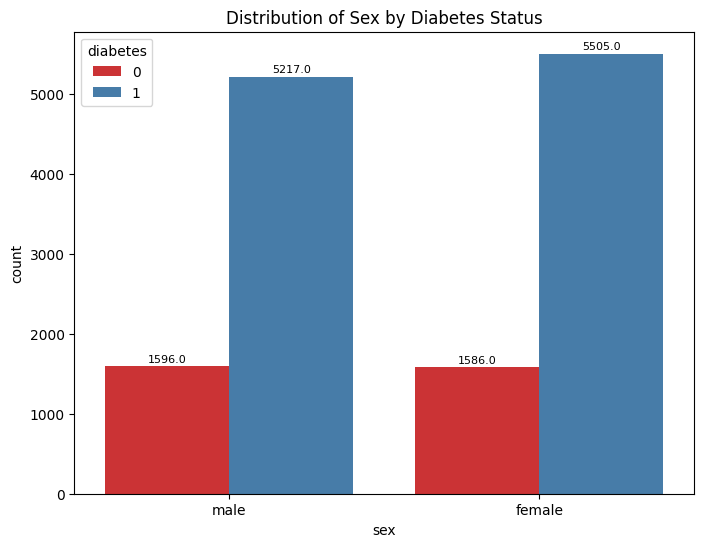

In [ ]:
# Create a countplot with hue
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='sex', hue='diabetes', data=claim_df, palette='Set1')
plt.title('Distribution of Sex by Diabetes Status')

# Add text labels above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

A slightly higher prevalence of diabetes is observed among females.

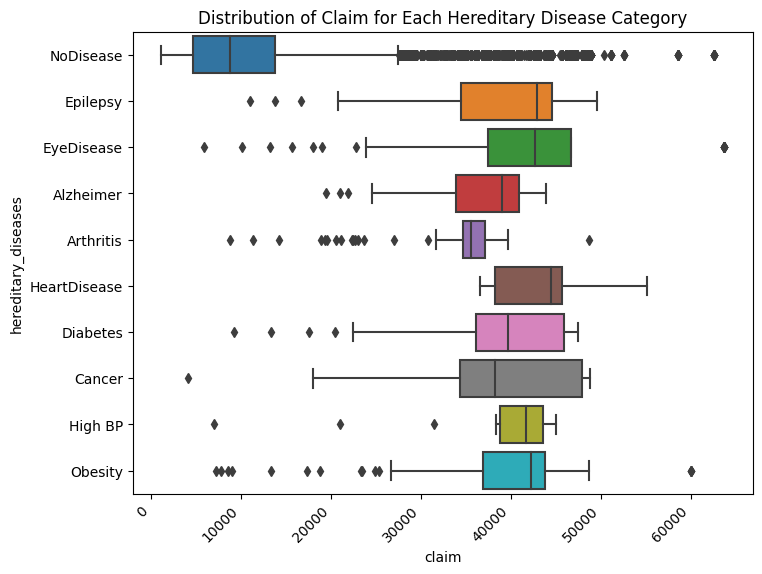

In [ ]:
#checking the distribution of claim for each hereditary diseases category
plt.figure(figsize=(8, 6))

# Use a horizontal boxplot and adjust the rotation of x-axis labels
sns.boxplot(x='claim', y='hereditary_diseases', data=claim_df, orient='h')
plt.title('Distribution of Claim for Each Hereditary Disease Category')

# Customize x-axis labels rotation and alignment
plt.xticks(rotation=45, ha='right')

plt.show()

In [ ]:
summary_stats = claim_df.groupby('hereditary_diseases')['claim'].describe()

# Display the summary statistics
print(summary_stats)

                       count          mean           std      min       25%  \
hereditary_diseases                                                           
Alzheimer              137.0  37540.527007   4667.026039  19517.2  33907.60   
Arthritis               88.0  33899.270455   6887.641631   8798.4  34672.20   
Cancer                 107.0  39445.370093   8639.448013   4123.8  34407.55   
Diabetes               136.0  39448.445588   7216.620503   9217.3  36154.75   
Epilepsy                77.0  39692.058442   8844.548431  11084.2  34439.90   
EyeDisease             112.0  41188.110714  10803.620025   5863.8  37484.50   
HeartDisease            87.0  43086.019540   5512.477847  36580.3  38245.60   
High BP                 65.0  40605.910769   5575.309297   7004.8  38792.70   
NoDisease            12965.0  11557.290343  10067.259506   1121.9   4686.40   
Obesity                130.0  39589.330769   9211.522014   7206.5  36880.70   

                          50%        75%      max  

Heart disease exhibits higher mean claim amounts when compared to other categories of hereditary diseases. However, population with no hereditary diseases has more outliers.

Number of Dependents

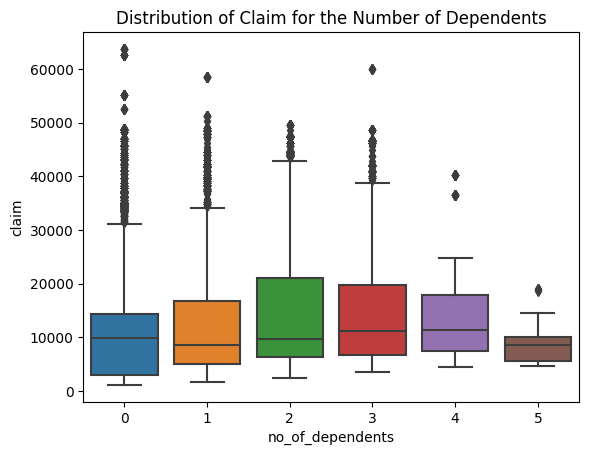

In [ ]:
#checking the distribution of claim for the number of dependents
sns.boxplot(x='no_of_dependents', y='claim', data=claim_df)
plt.title('Distribution of Claim for the Number of Dependents')
plt.show()

In [ ]:
summary_stats = claim_df.groupby('no_of_dependents')['claim'].describe()

# Display the summary statistics
print(summary_stats)

                   count          mean           std     min     25%      50%  \
no_of_dependents                                                                
0                 5837.0  12364.585626  11904.420749  1121.9  2855.4   9866.3   
1                 3366.0  13139.266815  12074.959891  1711.0  5012.5   8539.7   
2                 2527.0  15229.200198  12968.267957  2304.0  6312.0   9715.8   
3                 1678.0  15627.621275  12375.203255  3443.1  6746.7  11085.6   
4                  272.0  13862.855882   8392.902006  4504.7  7512.3  11299.3   
5                  224.0   8388.596875   3266.194828  4687.8  5615.4   8582.3   

                      75%      max  
no_of_dependents                    
0                 14283.5  63770.4  
1                 16796.4  58571.1  
2                 21068.3  49577.7  
3                 19749.4  60021.4  
4                 17942.1  40182.3  
5                 10097.0  19023.3  


Population with 3 children exhibits higher mean claim amounts when compared to other population. However, population with no kids have more and higher claim outliers

#### Anomaly Analysis


The dataset indicates a minimum blood pressure value of zero, which is not physiologically plausible. To address this anomaly, we will explore various methods to rectify or handle the zero values in the blood pressure column

In [ ]:
zero_blood_pressure_count = (claim_df['bloodpressure'] == 0).sum()

print(f"The number of data points with a blood pressure value of 0 is: {zero_blood_pressure_count}")

The number of data points with a blood pressure value of 0 is: 703


<Axes: xlabel='bloodpressure', ylabel='Count'>

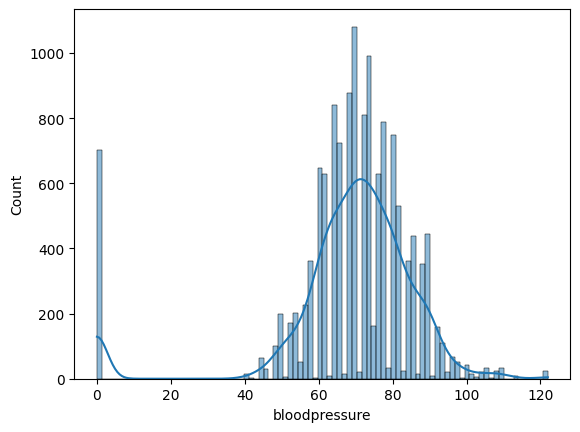

In [ ]:
sns.histplot(claim_df["bloodpressure"], kde = True)

In [ ]:
claim_df["bloodpressure"].describe()

count    13904.000000
mean        68.657652
std         19.430514
min          0.000000
25%         64.000000
50%         71.000000
75%         80.000000
max        122.000000
Name: bloodpressure, dtype: float64

In [ ]:
#Replace the zeros with NAN
claim_df['bloodpressure'] = claim_df['bloodpressure'].replace(0, np.nan)

# Impute missing values with the mean
claim_df['bloodpressure'].fillna(claim_df['bloodpressure'].mean(), inplace=True)
claim_df.describe()

,age,weight,bmi,no_of_dependents,smoker,bloodpressure,diabetes,regular_ex,claim
count,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000
mean,39.552503,64.894347,30.273483,1.126438,0.200662,72.313916,0.771145,0.230725,13431.813744
std,13.920992,13.675070,5.923446,1.225661,0.400510,11.247061,0.420111,0.421312,12142.099413
min,18.000000,34.000000,16.000000,0.000000,0.000000,40.000000,0.000000,0.000000,1121.900000
25%,27.000000,54.000000,25.900000,0.000000,0.000000,64.000000,1.000000,0.000000,4883.900000
50%,40.000000,63.000000,29.900000,1.000000,0.000000,72.000000,1.000000,0.000000,9567.000000
75%,51.000000,76.000000,34.100000,2.000000,0.000000,80.000000,1.000000,0.000000,16657.700000
max,64.000000,95.000000,53.100000,5.000000,1.000000,122.000000,1.000000,1.000000,63770.400000


<Axes: xlabel='bloodpressure', ylabel='Count'>

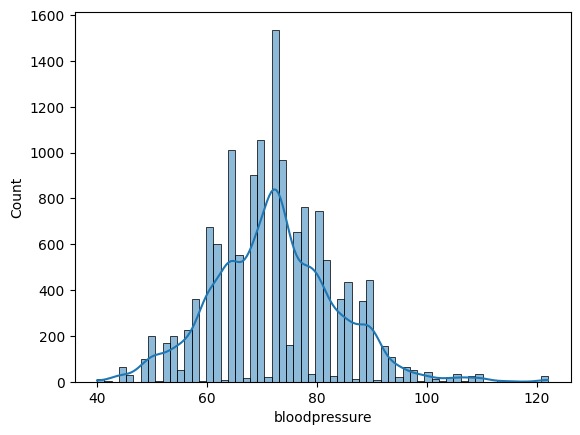

In [ ]:
sns.histplot(claim_df["bloodpressure"], kde = True)

#### Correlation Analysis

<Axes: >

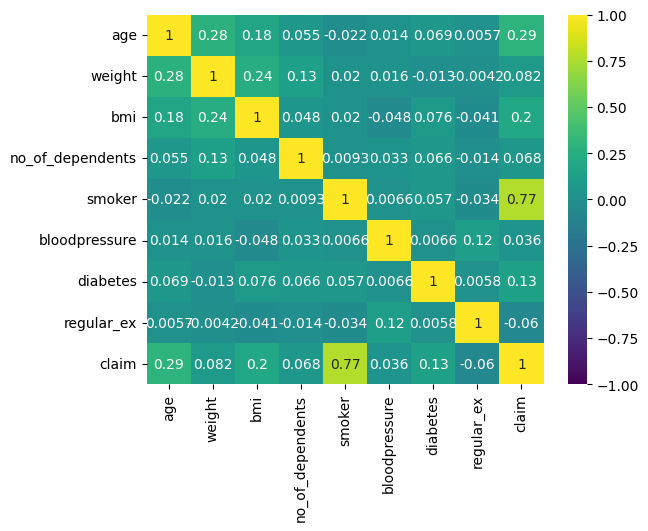

In [ ]:
sns.heatmap(claim_df.corr(),annot=True,cmap='viridis',vmin=-1,vmax=1)

The analysis reveals a positive correlation between the 'age,' 'bmi,' 'smoker,' and 'diabetes' columns with the amount of insurance claims, with 'smoker' demonstrating the strongest positive correlation among these features. This suggests that as the age, BMI, smoking status, and presence of diabetes increase, there is a corresponding increase in the amount of insurance claims. These features emerge as promising predictors for estimating the claim amount in the dataset.

Considering that the bmi value is derived from the weight, we will opt to exclude the weight column from our analysis to mitigate potential issues of multicollinearity. Also we will drop the regular exercise column as it doesn't have a strong correlation with the claim.

In [ ]:
claim_df = claim_df.drop('weight', axis=1)

In [ ]:
claim_df = claim_df.drop('regular_ex', axis=1)

### Feature Engineering

In [ ]:
claim_df['is_male'] = claim_df['sex'].apply(lambda x: 1 if x == 'male' else 0)
claim_df = claim_df.drop('sex', axis=1)
claim_df['is_male'].value_counts()

0    7091
1    6813
Name: is_male, dtype: int64

In [ ]:
claim_df = pd.get_dummies(claim_df, columns=['hereditary_diseases'], prefix='hereditary_disease')
# Drop the 'hereditary_disease_NoDisease' column
claim_df = claim_df.drop('hereditary_disease_NoDisease', axis=1)
claim_df.columns

Index(['age', 'bmi', 'no_of_dependents', 'smoker', 'city', 'bloodpressure',
       'diabetes', 'job_title', 'claim', 'is_male',
       'hereditary_disease_Alzheimer', 'hereditary_disease_Arthritis',
       'hereditary_disease_Cancer', 'hereditary_disease_Diabetes',
       'hereditary_disease_Epilepsy', 'hereditary_disease_EyeDisease',
       'hereditary_disease_HeartDisease', 'hereditary_disease_High BP',
       'hereditary_disease_Obesity'],
      dtype='object')

In [ ]:
# Define bin edges and labels for age
bin_edges = [18, 30, 45, 65]
bin_labels = ['Young Adult', 'Adult', 'Middle-Aged']

# Create age bins
claim_df['age_group'] = pd.cut(claim_df['age'], bins=bin_edges, labels=bin_labels, right=False)
claim_df.head(10)

,age,bmi,no_of_dependents,smoker,city,bloodpressure,diabetes,job_title,claim,is_male,hereditary_disease_Alzheimer,hereditary_disease_Arthritis,hereditary_disease_Cancer,hereditary_disease_Diabetes,hereditary_disease_Epilepsy,hereditary_disease_EyeDisease,hereditary_disease_HeartDisease,hereditary_disease_High BP,hereditary_disease_Obesity,age_group
0,60.0,24.300000,1,0,NewYork,72.0,0,Actor,13112.6,1,0,0,0,0,0,0,0,0,0,Middle-Aged
1,49.0,22.600000,1,0,Boston,78.0,1,Engineer,9567.0,0,0,0,0,0,0,0,0,0,0,Middle-Aged
2,32.0,17.800000,2,1,Phildelphia,88.0,1,Academician,32734.2,0,0,0,0,0,1,0,0,0,0,Adult
3,61.0,36.400000,1,1,Pittsburg,72.0,1,Chef,48517.6,0,0,0,0,0,0,0,0,0,0,Middle-Aged
4,19.0,20.600000,0,0,Buffalo,82.0,1,HomeMakers,1731.7,0,0,0,0,0,0,0,0,0,0,Young Adult
5,42.0,37.900000,0,0,AtlanticCity,78.0,0,Dancer,6474.0,0,0,0,0,0,0,0,0,0,0,Adult
6,18.0,23.800000,0,0,Portland,64.0,0,Singer,1705.6,1,0,0,0,0,0,0,0,0,0,Young Adult
7,21.0,26.800000,0,0,Cambridge,74.0,1,Actor,1534.3,1,0,0,0,0,0,0,0,0,0,Young Adult
8,63.0,30.273483,0,0,Hartford,70.0,1,Dancer,13390.6,1,0,0,0,0,0,0,0,0,0,Middle-Aged
9,40.0,29.600000,0,0,Springfield,64.0,1,DataScientist,5910.9,0,0,0,0,0,0,0,0,0,0,Adult


In [ ]:
claim_df['age_group'].value_counts()

Middle-Aged    5627
Adult          4272
Young Adult    4005
Name: age_group, dtype: int64

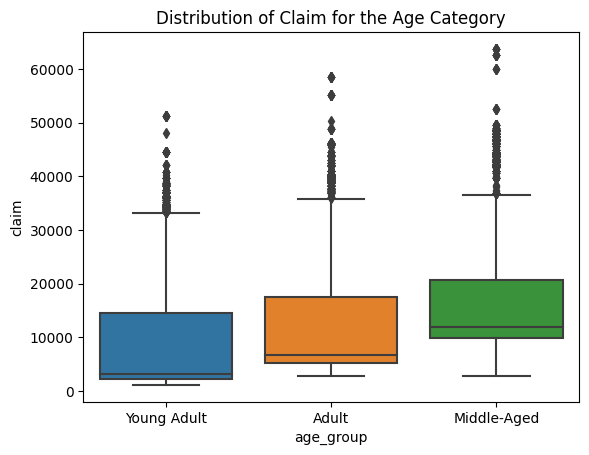

In [ ]:
#checking the distribution of claim for the age category
sns.boxplot(x='age_group', y='claim', data=claim_df)
plt.title('Distribution of Claim for the Age Category')
plt.show()

In [ ]:
summary_stats = claim_df.groupby('age_group')['claim'].describe()

# Display the summary statistics
print(summary_stats)

              count          mean           std     min     25%      50%  \
age_group                                                                  
Young Adult  4005.0   9400.670986  11569.533688  1121.9  2137.7   3227.1   
Adult        4272.0  12380.318001  11762.600306  2866.1  5261.5   6753.0   
Middle-Aged  5627.0  17099.259374  11754.662195  2866.1  9910.4  11987.2   

                 75%      max  
age_group                      
Young Adult  14571.9  51194.6  
Adult        17496.3  58571.1  
Middle-Aged  20709.0  63770.4  


Individuals in the middle-age demographic tend to exhibit a higher average claim amount.

In [ ]:
claim_df = pd.get_dummies(claim_df, columns=['age_group'], drop_first=True)
claim_df.drop(['age'], axis=1, inplace=True)
claim_df.columns

Index(['bmi', 'no_of_dependents', 'smoker', 'city', 'bloodpressure',
       'diabetes', 'job_title', 'claim', 'is_male',
       'hereditary_disease_Alzheimer', 'hereditary_disease_Arthritis',
       'hereditary_disease_Cancer', 'hereditary_disease_Diabetes',
       'hereditary_disease_Epilepsy', 'hereditary_disease_EyeDisease',
       'hereditary_disease_HeartDisease', 'hereditary_disease_High BP',
       'hereditary_disease_Obesity', 'age_group_Adult',
       'age_group_Middle-Aged'],
      dtype='object')

In [ ]:
# Define bin edges and labels for BMI
bmi_bin_edges = [0, 18.5, 25.0, 30.0, 100.0]
bmi_bin_labels = ['Underweight', 'Normalweight', 'Overweight', 'Obese']

# Create BMI bins
claim_df['bmi_category'] = pd.cut(claim_df['bmi'], bins=bmi_bin_edges, labels=bmi_bin_labels, right=False)
claim_df.head(10)

,bmi,no_of_dependents,smoker,city,bloodpressure,diabetes,job_title,claim,is_male,hereditary_disease_Alzheimer,...,hereditary_disease_Cancer,hereditary_disease_Diabetes,hereditary_disease_Epilepsy,hereditary_disease_EyeDisease,hereditary_disease_HeartDisease,hereditary_disease_High BP,hereditary_disease_Obesity,age_group_Adult,age_group_Middle-Aged,bmi_category
0,24.300000,1,0,NewYork,72.0,0,Actor,13112.6,1,0,...,0,0,0,0,0,0,0,0,1,Normalweight
1,22.600000,1,0,Boston,78.0,1,Engineer,9567.0,0,0,...,0,0,0,0,0,0,0,0,1,Normalweight
2,17.800000,2,1,Phildelphia,88.0,1,Academician,32734.2,0,0,...,0,0,1,0,0,0,0,1,0,Underweight
3,36.400000,1,1,Pittsburg,72.0,1,Chef,48517.6,0,0,...,0,0,0,0,0,0,0,0,1,Obese
4,20.600000,0,0,Buffalo,82.0,1,HomeMakers,1731.7,0,0,...,0,0,0,0,0,0,0,0,0,Normalweight
5,37.900000,0,0,AtlanticCity,78.0,0,Dancer,6474.0,0,0,...,0,0,0,0,0,0,0,1,0,Obese
6,23.800000,0,0,Portland,64.0,0,Singer,1705.6,1,0,...,0,0,0,0,0,0,0,0,0,Normalweight
7,26.800000,0,0,Cambridge,74.0,1,Actor,1534.3,1,0,...,0,0,0,0,0,0,0,0,0,Overweight
8,30.273483,0,0,Hartford,70.0,1,Dancer,13390.6,1,0,...,0,0,0,0,0,0,0,0,1,Obese
9,29.600000,0,0,Springfield,64.0,1,DataScientist,5910.9,0,0,...,0,0,0,0,0,0,0,1,0,Overweight


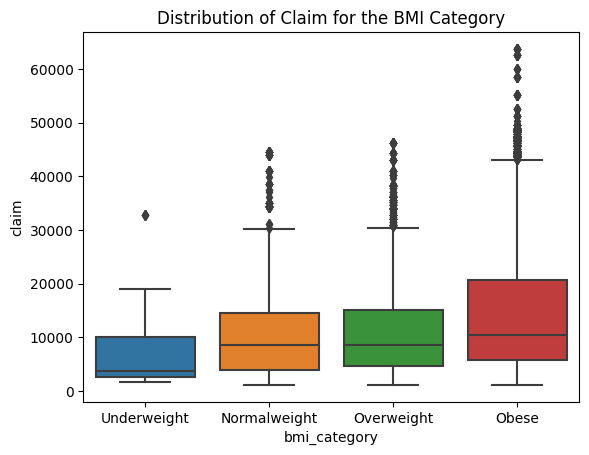

In [ ]:
#checking the distribution of claim for the bmi category
sns.boxplot(x='bmi_category', y='claim', data=claim_df)
plt.title('Distribution of Claim for the BMI Category')
plt.show()

In [ ]:
summary_stats = claim_df.groupby('bmi_category')['claim'].describe()

# Display the summary statistics
print(summary_stats)

               count          mean           std     min     25%      50%  \
bmi_category                                                                
Underweight    190.0   6383.668947   5924.383380  1621.3  2585.3   3732.6   
Normalweight  2370.0  10757.287089   8878.131508  1121.9  3847.7   8603.8   
Overweight    4519.0  11500.341005   9268.781121  1146.8  4571.4   8606.2   
Obese         6825.0  15835.638066  14249.165893  1131.5  5662.2  10435.1   

                  75%      max  
bmi_category                    
Underweight    9991.0  32734.2  
Normalweight  14455.6  44585.5  
Overweight    14988.4  46113.5  
Obese         20630.3  63770.4  


Individuals that are obese tend to exhibit a higher average claim amount.

In [ ]:
claim_df = pd.get_dummies(claim_df, columns=['bmi_category'], drop_first=True)
claim_df.drop(['bmi'], axis=1, inplace=True)
claim_df.columns

Index(['no_of_dependents', 'smoker', 'city', 'bloodpressure', 'diabetes',
       'job_title', 'claim', 'is_male', 'hereditary_disease_Alzheimer',
       'hereditary_disease_Arthritis', 'hereditary_disease_Cancer',
       'hereditary_disease_Diabetes', 'hereditary_disease_Epilepsy',
       'hereditary_disease_EyeDisease', 'hereditary_disease_HeartDisease',
       'hereditary_disease_High BP', 'hereditary_disease_Obesity',
       'age_group_Adult', 'age_group_Middle-Aged', 'bmi_category_Normalweight',
       'bmi_category_Overweight', 'bmi_category_Obese'],
      dtype='object')

Drop the job title column under the assumption that this feature is unrelated to the insurance claim amount.

In [ ]:
claim_df = claim_df.drop('job_title', axis=1)

To encode the city column, we will employ the frequency method

In [ ]:
#Define the region mapping
region_mapping = {
  "Northeast": ["Augusta","Bangor","Portland","Lewiston","South Portland","Montpelier","Burlington","South Burlington","Rutland","Bennington",
    "Concord","Manchester","Nashua","Dover","Rochester","Boston","Worcester","Springfield","Lowell","Cambridge","Providence","Warwick",
    "Cranston","Pawtucket","East Providence","Hartford","New Haven","Bridgeport","Stamford","Waterbury","New York City","Buffalo","Rochester",
    "Yonkers","Syracuse","Philadelphia","Phildelphia","Pittsburgh","Pittsburg","Allentown","Erie","Reading","Newark","Jersey City","Paterson","Elizabeth","Edison","Dover",
    "Wilmington","Newark","Middletown","Smyrna","NewYork","AtlanticCity","York","Trenton", "Harrisburg", "Newport"],
  "Southeast": ["Annapolis","Baltimore","Rockville","Gaithersburg","Frederick","Richmond","Virginia Beach","Norfolk","Chesapeake","Arlington",
    "Washington D.C.","Charleston","Huntington","Parkersburg","Wheeling","Morgantown","Raleigh","Charlotte","Greensboro","Durham","Winston-Salem",
    "Columbia","Charleston","North Charleston","Mount Pleasant","Rock Hill","Atlanta","Augusta","Columbus","Savannah","Athens","Jacksonville",
    "Miami","Tampa","Orlando","St. Petersburg","Montgomery","Birmingham","Huntsville","Mobile","Tuscaloosa","Jackson","Gulfport","Biloxi",
    "Hattiesburg","Southaven","Baton Rouge","New Orleans","Shreveport","Lafayette","Lake Charles","Nashville","Memphis","Knoxville","Chattanooga",
    "Clarksville","WashingtonDC","Brimingham","Louisville","NewOrleans","Georgia","Macon","Florence","PanamaCity","Kingsport"],
  "Southwest": ["Austin","Houston","San Antonio","Dallas","Fort Worth","Oklahoma City","Tulsa","Norman","Lawton","Edmond","Little Rock",
    "Fort Smith","Fayetteville","Springdale","Jonesboro","Albuquerque","Santa Fe","Las Cruces","Rio Rancho","Roswell","Phoenix","Tucson",
    "Mesa","Chandler","Scottsdale","Las Vegas","Henderson","Reno","North Las Vegas","Sparks","Salt Lake City","West Valley City","Provo",
    "Orem","Sandy","Oklahoma","Prescott","LasVegas","Denver","Kingman","SilverCity","Pheonix","SantaFe","Lovelock"],
  "Northwest": ["Helena","Billings","Missoula","Great Falls","Bozeman","Boise","Meridian","Nampa","Idaho Falls","Caldwell","Cheyenne","Casper",
    "Laramie","Gillette","Rock Springs","Portland","Salem","Eugene","Gresham","Hillsboro","Seattle","Spokane","Tacoma","Vancouver","Bellevue",
    "Anchorage","Fairbanks","Juneau","Sitka","Ketchikan","FallsCity","SantaRosa","Eureka","SanFrancisco","SanJose","LosAngeles","Oxnard","SanDeigo",
                "Oceanside","Carlsbad","Montrose","Fresno","SanLuis","Bakersfield","Mexicali"],
  "Northcentral": ["Marshall","Mandan","Waterloo","IowaCity","Indianapolis","Cincinnati","Bloomington","Salina","KanasCity","Brookings",
                   "Minot","Chicago","Lincoln","GrandForks","Fargo","Cleveland","Canton","Minneapolis","JeffersonCity","Escabana","Youngstown"]
}


In [ ]:
# Define a function to map city to region
def get_region(city):
  for region, cities in region_mapping.items():
    if city in cities:
      return region
  return None

# Apply the mapping function to the city column and create a new 'region' column
claim_df["region"] = claim_df["city"].apply(get_region)

In [ ]:
# Check for missing values
missing_cities = claim_df[claim_df["region"].isnull()]["city"].unique()

if missing_cities.size == 0:
  print("All cities have been assigned regions.")
else:
  print(f"Warning: Missing regions for cities: {missing_cities}")

All cities have been assigned regions.


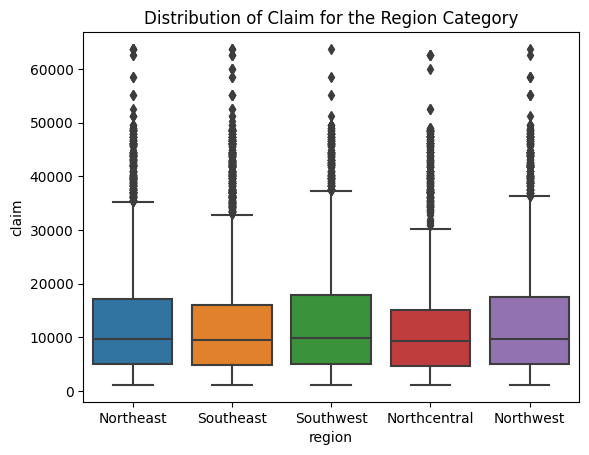

In [ ]:
#checking the distribution of claim for the region category
sns.boxplot(x='region', y='claim', data=claim_df)
plt.title('Distribution of Claim for the Region Category')
plt.show()

In [ ]:
summary_stats = claim_df.groupby('region')['claim'].describe()

# Display the summary statistics
print(summary_stats)

               count          mean           std     min       25%      50%  \
region                                                                        
Northcentral  2314.0  12968.297148  11862.871078  1121.9  4718.525  9222.40   
Northeast     3015.0  13583.387828  12230.197251  1121.9  4933.200  9704.70   
Northwest     2388.0  13585.308333  12191.565920  1121.9  5003.900  9620.30   
Southeast     4070.0  13261.288722  12054.166454  1121.9  4830.600  9412.95   
Southwest     2117.0  13877.290033  12416.223463  1121.9  4992.400  9861.00   

                    75%      max  
region                            
Northcentral  15170.100  62592.9  
Northeast     17081.100  63770.4  
Northwest     17561.325  63770.4  
Southeast     16069.100  63770.4  
Southwest     17929.300  63770.4  


Population who resides in the Southwestern part of the US exhibits higher mean claim amounts when compared to other regions.

In [ ]:
claim_df = pd.get_dummies(claim_df, columns=['region'], drop_first=True)
claim_df.drop(['city'], axis=1, inplace=True)
claim_df.columns

Index(['no_of_dependents', 'smoker', 'bloodpressure', 'diabetes', 'claim',
       'is_male', 'hereditary_disease_Alzheimer',
       'hereditary_disease_Arthritis', 'hereditary_disease_Cancer',
       'hereditary_disease_Diabetes', 'hereditary_disease_Epilepsy',
       'hereditary_disease_EyeDisease', 'hereditary_disease_HeartDisease',
       'hereditary_disease_High BP', 'hereditary_disease_Obesity',
       'age_group_Adult', 'age_group_Middle-Aged', 'bmi_category_Normalweight',
       'bmi_category_Overweight', 'bmi_category_Obese', 'region_Northeast',
       'region_Northwest', 'region_Southeast', 'region_Southwest'],
      dtype='object')

In [ ]:
claim_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13904 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   no_of_dependents                 13904 non-null  int64  
 1   smoker                           13904 non-null  int64  
 2   bloodpressure                    13904 non-null  float64
 3   diabetes                         13904 non-null  int64  
 4   claim                            13904 non-null  float64
 5   is_male                          13904 non-null  int64  
 6   hereditary_disease_Alzheimer     13904 non-null  uint8  
 7   hereditary_disease_Arthritis     13904 non-null  uint8  
 8   hereditary_disease_Cancer        13904 non-null  uint8  
 9   hereditary_disease_Diabetes      13904 non-null  uint8  
 10  hereditary_disease_Epilepsy      13904 non-null  uint8  
 11  hereditary_disease_EyeDisease    13904 non-null  uint8  
 12  hereditary_disease

In [ ]:
#save the data as processed_data 2
claim_df.to_csv('processed_data.csv')

## Modeling

In [ ]:
cleaned_claim_df = pd.read_csv("/content/drive/My Drive/DSHC-Final-Project/processed_data.csv", index_col=False)

print(cleaned_claim_df.shape)
cleaned_claim_df.head()

(13904, 25)


,Unnamed: 0,no_of_dependents,smoker,bloodpressure,diabetes,claim,is_male,hereditary_disease_Alzheimer,hereditary_disease_Arthritis,hereditary_disease_Cancer,...,hereditary_disease_Obesity,age_group_Adult,age_group_Middle-Aged,bmi_category_Normalweight,bmi_category_Overweight,bmi_category_Obese,region_Northeast,region_Northwest,region_Southeast,region_Southwest
0,0,1,0,72.0,0,13112.6,1,0,0,0,...,0,0,1,1,0,0,1,0,0,0
1,1,1,0,78.0,1,9567.0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0
2,2,2,1,88.0,1,32734.2,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,3,1,1,72.0,1,48517.6,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
4,4,0,0,82.0,1,1731.7,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [ ]:
cleaned_claim_df.columns

Index(['Unnamed: 0', 'no_of_dependents', 'smoker', 'bloodpressure', 'diabetes',
       'claim', 'is_male', 'hereditary_disease_Alzheimer',
       'hereditary_disease_Arthritis', 'hereditary_disease_Cancer',
       'hereditary_disease_Diabetes', 'hereditary_disease_Epilepsy',
       'hereditary_disease_EyeDisease', 'hereditary_disease_HeartDisease',
       'hereditary_disease_High BP', 'hereditary_disease_Obesity',
       'age_group_Adult', 'age_group_Middle-Aged', 'bmi_category_Normalweight',
       'bmi_category_Overweight', 'bmi_category_Obese', 'region_Northeast',
       'region_Northwest', 'region_Southeast', 'region_Southwest'],
      dtype='object')

In [ ]:
cleaned_claim_df = cleaned_claim_df.drop('Unnamed: 0', axis = 1)
cleaned_claim_df.describe()

,no_of_dependents,smoker,bloodpressure,diabetes,claim,is_male,hereditary_disease_Alzheimer,hereditary_disease_Arthritis,hereditary_disease_Cancer,hereditary_disease_Diabetes,...,hereditary_disease_Obesity,age_group_Adult,age_group_Middle-Aged,bmi_category_Normalweight,bmi_category_Overweight,bmi_category_Obese,region_Northeast,region_Northwest,region_Southeast,region_Southwest
count,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,...,13904.000000,13904.00000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000
mean,1.126438,0.200662,72.313916,0.771145,13431.813744,0.490003,0.009853,0.006329,0.007696,0.009781,...,0.009350,0.30725,0.404704,0.170455,0.325014,0.490866,0.216844,0.171749,0.292722,0.152258
std,1.225661,0.400510,11.247061,0.420111,12142.099413,0.499918,0.098777,0.079306,0.087390,0.098419,...,0.096245,0.46137,0.490852,0.376045,0.468397,0.499935,0.412110,0.377176,0.455028,0.359284
min,0.000000,0.000000,40.000000,0.000000,1121.900000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,64.000000,1.000000,4883.900000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,72.000000,1.000000,9567.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,80.000000,1.000000,16657.700000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.00000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,5.000000,1.000000,122.000000,1.000000,63770.400000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Splitting the data into training, validation, and holdout sets

In [ ]:
X = cleaned_claim_df.drop('claim', axis=1)
y = cleaned_claim_df['claim']

# X_train_test, X_holdout, y_train_test, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42) #20% for holdout, 80% for training+testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(f'Training Set: {X_train.shape}')
print(f'Testing Set: {X_test.shape}')

Training Set: (11123, 23)
Testing Set: (2781, 23)


Data Scaling

In [ ]:
# Fit the scaler on the training data only
scaler = StandardScaler().fit(X_train)

# Use the fitted scaler to transform the train, test, and holdout data separately
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
scaled_df = pd.DataFrame(X_train_scaled,columns=X_train.columns)
scaled_df.head()

,no_of_dependents,smoker,bloodpressure,diabetes,is_male,hereditary_disease_Alzheimer,hereditary_disease_Arthritis,hereditary_disease_Cancer,hereditary_disease_Diabetes,hereditary_disease_Epilepsy,...,hereditary_disease_Obesity,age_group_Adult,age_group_Middle-Aged,bmi_category_Normalweight,bmi_category_Overweight,bmi_category_Obese,region_Northeast,region_Northwest,region_Southeast,region_Southwest
0,0.701196,2.001462,1.755494,0.545663,1.023563,-0.099019,-0.077846,-0.082944,-0.099941,-0.076669,...,-0.098089,1.495410,-0.821368,-0.454600,-0.697307,1.024668,-0.526622,2.199738,-0.644034,-0.424747
1,-0.924526,-0.499635,0.685014,0.545663,-0.976980,-0.099019,-0.077846,-0.082944,-0.099941,-0.076669,...,-0.098089,-0.668713,1.217480,-0.454600,1.434088,-0.975926,-0.526622,-0.454600,-0.644034,-0.424747
2,-0.924526,-0.499635,-0.207052,0.545663,1.023563,-0.099019,-0.077846,-0.082944,-0.099941,-0.076669,...,-0.098089,-0.668713,1.217480,2.199738,-0.697307,-0.975926,-0.526622,-0.454600,-0.644034,-0.424747
3,0.701196,-0.499635,-2.169598,0.545663,-0.976980,-0.099019,-0.077846,-0.082944,-0.099941,-0.076669,...,-0.098089,-0.668713,1.217480,-0.454600,-0.697307,1.024668,-0.526622,-0.454600,1.552713,-0.424747
4,-0.111665,2.001462,0.506601,0.545663,1.023563,-0.099019,-0.077846,-0.082944,-0.099941,-0.076669,...,-0.098089,-0.668713,-0.821368,-0.454600,-0.697307,1.024668,-0.526622,2.199738,-0.644034,-0.424747


Building models

#### Linear Regression

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_ypred = lr_model.predict(X_test_scaled)

# Evaluate the model
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_ypred))
print(f'RMSE of Linear Regression: {lr_rmse}')

RMSE of Linear Regression: 6116.488137364747


In [ ]:
# Evaluate model on training data
lr_ypred_train = lr_model.predict(X_train_scaled)
lr_rmse_train = np.sqrt(mean_squared_error(y_train, lr_ypred_train))
print(f'Train RMSE of Linear Regression: {lr_rmse_train}')

# Cross-validation with 5 cv folds
lr_cv_rmse = np.sqrt(-cross_val_score(lr_model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5))
print(f'CV RMSE of Linear Regression: {lr_cv_rmse.mean()}')

Train RMSE of Linear Regression: 6055.629106600995
CV RMSE of Linear Regression: 6069.144610340643


#### Decision Tree


In [ ]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_ypred = dt_model.predict(X_test_scaled)

# Evaluate the model
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_ypred))
print(f'RMSE of Decision Tree: {dt_rmse}')

RMSE of Decision Tree: 3957.4785218263723


In [ ]:
# Evaluate model on training data
dt_ypred_train = dt_model.predict(X_train_scaled)
dt_rmse_train = np.sqrt(mean_squared_error(y_train, dt_ypred_train))
print(f'Train RMSE of Decision Tree: {dt_rmse_train}')

# Cross-validation with 5 cv folds
dt_cv_rmse = np.sqrt(-cross_val_score(dt_model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5))
print(f'CV RMSE of Decision Tree: {dt_cv_rmse.mean()}')

Train RMSE of Decision Tree: 1748.3853162581152
CV RMSE of Decision Tree: 4000.220374882732


##### Hyperparameter Tuning

In [ ]:
%%time

# Define the parameter distribution for Random Search
param_dist_dt = {
    'max_depth': np.arange(3, 20),
    'min_samples_split': np.arange(2, 50),
    'min_samples_leaf': np.arange(1, 50),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

dt_model = DecisionTreeRegressor(random_state=42)

# Set up RandomizedSearchCV
random_search_dt = RandomizedSearchCV(dt_model, param_distributions=param_dist_dt,
                                      n_iter=100, scoring='neg_root_mean_squared_error',
                                      cv=5, random_state=42, n_jobs=-1, verbose=1)

# Perform the Random Search
random_search_dt.fit(X_train_scaled, y_train)

# Get the best hyperparameters
dt_best_params = random_search_dt.best_params_

# Create a new model with the best hyperparameters
best_dt_model = DecisionTreeRegressor(**dt_best_params)
best_dt_model.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 520 ms, sys: 107 ms, total: 626 ms
Wall time: 9.79 s


DecisionTreeRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=9)

In [ ]:
# Save the model to a file
filename = '/content/drive/My Drive/DSHC-Final-Project/dt_best_model_rs.joblib'
joblib.dump(best_dt_model, filename)

print(f"Model saved as {filename}")

Model saved as /content/drive/My Drive/DSHC-Final-Project/dt_best_model_rs.joblib


In [ ]:
# load model
best_dt_model=joblib.load('/content/drive/My Drive/DSHC-Final-Project/dt_best_model_rs.joblib')

In [ ]:
best_dt_ypred = best_dt_model.predict(X_test_scaled)

# Evaluate the model
best_dt_rmse = np.sqrt(mean_squared_error(y_test, best_dt_ypred))
print(f'RMSE of tuned Decision Tree model: {best_dt_rmse}')

# Evaluate model on training data
dt_ypred_train2 = best_dt_model.predict(X_train_scaled)
dt_rmse_train2 = np.sqrt(mean_squared_error(y_train, dt_ypred_train2))
print(f'Train RMSE of tuned Decision Tree model: {dt_rmse_train2}')

# Cross-validation with 5 cv folds
dt_cv_rmse2 = np.sqrt(-cross_val_score(best_dt_model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5))
print(f'CV RMSE of tuned Decision Tree model: {dt_cv_rmse2.mean()}')

RMSE of tuned Decision Tree model: 3746.3801726979127
Train RMSE of tuned Decision Tree model: 3033.5151735592153
CV RMSE of tuned Decision Tree model: 3935.823318422389


#### Random Forest

In [ ]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_ypred = rf_model.predict(X_test_scaled)

# Evaluate the model
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_ypred))
print(f'RMSE for Random Forest: {rf_rmse}')

RMSE for Random Forest: 3433.784962729753


In [ ]:
# Evaluate model on training data
rf_ypred_train = rf_model.predict(X_train_scaled)
rf_rmse_train = np.sqrt(mean_squared_error(y_train, rf_ypred_train))
print(f'Train RMSE of Random Forest: {rf_rmse_train}')

# Cross-validation with 5 cv folds
rf_cv_rmse = np.sqrt(-cross_val_score(rf_model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5))
print(f'CV RMSE of Random Forest: {rf_cv_rmse.mean()}')

Train RMSE of Random Forest: 1969.9764548418493
CV RMSE of Random Forest: 3407.611525540732


Feature Importance

                            Feature  Importance
1                            smoker    0.606144
18               bmi_category_Obese    0.100574
2                     bloodpressure    0.084492
15            age_group_Middle-Aged    0.070004
0                  no_of_dependents    0.028248
3                          diabetes    0.027294
4                           is_male    0.012442
14                  age_group_Adult    0.009672
11  hereditary_disease_HeartDisease    0.009648
5      hereditary_disease_Alzheimer    0.008602
17          bmi_category_Overweight    0.007685
16        bmi_category_Normalweight    0.005861
9       hereditary_disease_Epilepsy    0.004336
19                 region_Northeast    0.003426
20                 region_Northwest    0.003106
7         hereditary_disease_Cancer    0.003069
21                 region_Southeast    0.002942
13       hereditary_disease_Obesity    0.002713
6      hereditary_disease_Arthritis    0.002673
10    hereditary_disease_EyeDisease    0

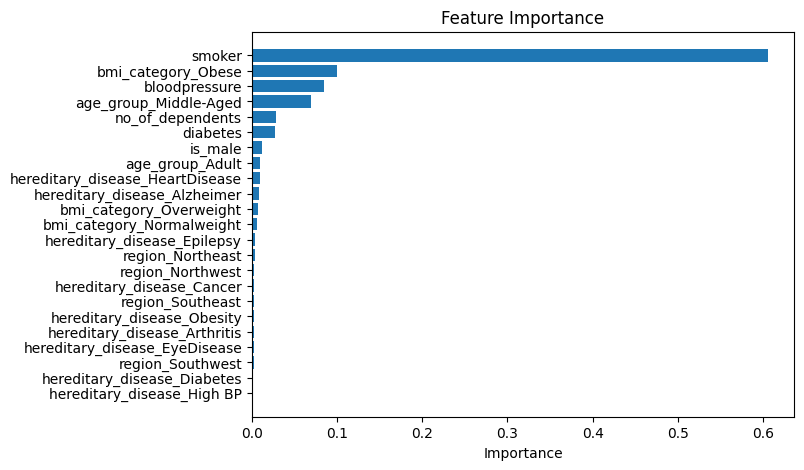

In [ ]:
feature_importance = rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to display the feature importance values along with feature names
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)
print(feature_importance_df.sort_values(by = 'Importance', ascending = False))

# Plot the feature importance
plt.figure(figsize=(7,5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

Selecting important features for re-builing models

In [ ]:
selected_features = ['smoker', 'bmi_category_Obese', 'bloodpressure', 'age_group_Middle-Aged', 'no_of_dependents', 'diabetes',
                     'hereditary_disease_HeartDisease', 'is_male', 'age_group_Adult', 'hereditary_disease_Alzheimer', 'bmi_category_Overweight']

X_train_selected = X_train_scaled[:, [X_train.columns.get_loc(c) for c in selected_features]]
X_test_selected = X_test_scaled[:, [X_test.columns.get_loc(c) for c in selected_features]]

In [ ]:
# Re-train the Random Forest model using only the selected features
rf_model_selected = RandomForestRegressor(random_state=42)
rf_model_selected.fit(X_train_selected, y_train)

# Make predictions on the validation set using the selected features
rf_ypred_selected = rf_model_selected.predict(X_test_selected)

# Evaluate the model performance on testing data
rf_rmse_selected = mean_squared_error(y_test, rf_ypred_selected, squared=False)
print(f"RMSE of Random Forest with selected features: {rf_rmse_selected}")


# Evaluate model on training data
rf_ypred_train_selected = rf_model_selected.predict(X_train_selected)
rf_rmse_train_selected = np.sqrt(mean_squared_error(y_train, rf_ypred_train_selected))
print(f'Train RMSE of Random Forest with selected features: {rf_rmse_train_selected}')

# Cross-validation with 5 cv folds
rf_cv_rmse_selected = np.sqrt(-cross_val_score(rf_model_selected, X_train_selected, y_train, scoring='neg_mean_squared_error', cv=5))
print(f'CV RMSE of Random Forest with selected features: {rf_cv_rmse_selected.mean()}')

RMSE of Random Forest with selected features: 3289.4130850828183
Train RMSE of Random Forest with selected features: 2290.191744223252
CV RMSE of Random Forest with selected features: 3304.232483075242


##### Hyperparameter Tuning

In [ ]:
%%time

param_dist_rf = {
    'n_estimators': np.arange(100, 500, 100),
    'max_depth': np.arange(3, 20),
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 5),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

rf = RandomForestRegressor(random_state=42)

random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf, cv=5, n_iter=100, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1)
random_search_rf.fit(X_train_scaled, y_train)

# Get the best hyperparameters
rf_best_params = random_search_rf.best_params_

# Create a new model with the best hyperparameters
best_rf_model = RandomForestRegressor(**rf_best_params)
best_rf_model.fit(X_train_scaled, y_train)

CPU times: user 23.9 s, sys: 1.99 s, total: 25.8 s
Wall time: 17min 22s


RandomForestRegressor(max_depth=16, max_features='auto', min_samples_split=8,
                      n_estimators=300)

In [ ]:
# Save the model to a file
filename = '/content/drive/My Drive/DSHC-Final-Project/rf_best_model_rs.joblib'
joblib.dump(best_rf_model, filename)

print(f"Model saved as {filename}")

Model saved as /content/drive/My Drive/DSHC-Final-Project/rf_best_model_rs.joblib


In [ ]:
# load model
best_rf_model=joblib.load('/content/drive/My Drive/DSHC-Final-Project/rf_best_model_rs.joblib')

In [ ]:
best_rf_ypred = best_rf_model.predict(X_test_scaled)

# Evaluate the model
best_rf_rmse = np.sqrt(mean_squared_error(y_test, best_rf_ypred))
print(f'RMSE of tuned Random Forest model: {best_rf_rmse}')

# Evaluate model on training data
rf_ypred_train2 = best_rf_model.predict(X_train_scaled)
rf_rmse_train2 = np.sqrt(mean_squared_error(y_train, rf_ypred_train2))
print(f'Train RMSE of tuned Random Forest model: {rf_rmse_train2}')

# Cross-validation with 5 cv folds
rf_cv_rmse2 = np.sqrt(-cross_val_score(best_rf_model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5))
print(f'CV RMSE of tuned Random Forest model: {rf_cv_rmse2.mean()}')

RMSE of tuned Random Forest model: 3423.2143885744067
Train RMSE of tuned Random Forest model: 2454.5650902593097
CV RMSE of tuned Random Forest model: 3411.781273580725


Tunning and rerunning RF on selected features

In [ ]:
%%time

param_dist_rf = {
    'n_estimators': np.arange(100, 500, 100),
    'max_depth': np.arange(3, 20),
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 5),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

rf = RandomForestRegressor(random_state=42)

random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf, cv=5, n_iter=100, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1)
random_search_rf.fit(X_train_selected, y_train)

# Get the best hyperparameters
rf_best_params = random_search_rf.best_params_

# Create a new model with the best hyperparameters
best_rf_model = RandomForestRegressor(**rf_best_params)
best_rf_model.fit(X_train_selected, y_train)

CPU times: user 16.2 s, sys: 1.69 s, total: 17.9 s
Wall time: 12min 58s


RandomForestRegressor(max_depth=18, max_features='sqrt', min_samples_split=3,
                      n_estimators=400)

In [ ]:
# Save the model to a file
filename = '/content/drive/My Drive/DSHC-Final-Project/rf_best_model_rs_selected.joblib'
joblib.dump(best_rf_model, filename)

print(f"Model saved as {filename}")

Model saved as /content/drive/My Drive/DSHC-Final-Project/rf_best_model_rs_selected.joblib


In [ ]:
# load model
best_rf_model2=joblib.load('/content/drive/My Drive/DSHC-Final-Project/rf_best_model_rs_selected.joblib')

In [ ]:
best_rf_ypred2 = best_rf_model2.predict(X_test_selected)

# Evaluate the model
best_rf_rmse2 = np.sqrt(mean_squared_error(y_test, best_rf_ypred2))
print(f'RMSE of tuned Random Forest model with selected features: {best_rf_rmse2}')

# Evaluate model on training data
rf_ypred_train3 = best_rf_model2.predict(X_train_selected)
rf_rmse_train3 = np.sqrt(mean_squared_error(y_train, rf_ypred_train3))
print(f'Train RMSE of tuned Random Forest model with selected features: {rf_rmse_train3}')

# Cross-validation with 5 cv folds
rf_cv_rmse3 = np.sqrt(-cross_val_score(best_rf_model2, X_train_selected, y_train, scoring='neg_mean_squared_error', cv=5))
print(f'CV RMSE of tuned Random Forest model with selected features: {rf_cv_rmse3.mean()}')

RMSE of tuned Random Forest model with selected features: 3207.0385129012193
Train RMSE of tuned Random Forest model with selected features: 2344.852942242043
CV RMSE of tuned Random Forest model with selected features: 3256.683755554219


#### XGBoost

In [ ]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_ypred = xgb_model.predict(X_test_scaled)

# Evaluate the model
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_ypred))
print(f'RMSE of XGBoost: {xgb_rmse}')

RMSE of XGBoost: 4014.992397436905


In [ ]:
# Evaluate model on training data
xgb_ypred_train = xgb_model.predict(X_train_scaled)
xgb_rmse_train = np.sqrt(mean_squared_error(y_train, xgb_ypred_train))
print(f'Train RMSE of XGBoost: {xgb_rmse_train}')

# Cross-validation with 5 cv folds
xgb_cv_rmse = np.sqrt(-cross_val_score(xgb_model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5))
print(f'CV RMSE of XGBoost: {xgb_cv_rmse.mean()}')

Train RMSE of XGBoost: 3234.80471681731
CV RMSE of XGBoost: 3887.431813728386


Feature Importance

                            Feature  Importance
1                            smoker    0.529957
18               bmi_category_Obese    0.182290
15            age_group_Middle-Aged    0.060125
11  hereditary_disease_HeartDisease    0.056968
5      hereditary_disease_Alzheimer    0.036792
9       hereditary_disease_Epilepsy    0.021476
3                          diabetes    0.013721
6      hereditary_disease_Arthritis    0.011945
7         hereditary_disease_Cancer    0.011147
13       hereditary_disease_Obesity    0.010863
14                  age_group_Adult    0.008298
16        bmi_category_Normalweight    0.008262
10    hereditary_disease_EyeDisease    0.007318
2                     bloodpressure    0.007067
4                           is_male    0.006919
17          bmi_category_Overweight    0.006651
0                  no_of_dependents    0.006528
8       hereditary_disease_Diabetes    0.005510
12       hereditary_disease_High BP    0.002418
20                 region_Northwest    0

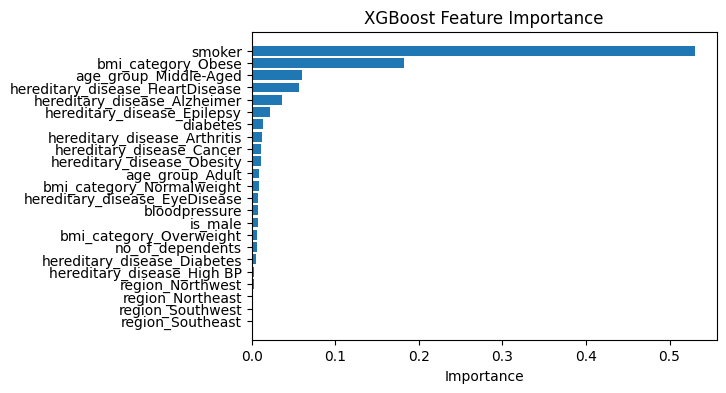

In [ ]:
# feature_importance = xgb_model.feature_importances_
# feature_names = X_train.columns

# # Create a DataFrame to display the feature importance values along with feature names
# feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)
# print(feature_importance_df.sort_values(by = 'Importance', ascending = False))

# # Plot the feature importance
# plt.figure(figsize=(6,4))
# plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
# plt.xlabel('Importance')
# plt.title('XGBoost Feature Importance')
# plt.show()

Selecting important features for re-builing models

In [ ]:
importances = pd.Series(feature_importance, index=X_train.columns)
sorted_importances = importances.sort_values(ascending=False)

# Get the top features (from Random Forest)
top_features = sorted_importances.head(11).index.tolist()
top_features

['smoker',
 'bmi_category_Obese',
 'bloodpressure',
 'age_group_Middle-Aged',
 'no_of_dependents',
 'diabetes',
 'is_male',
 'age_group_Adult',
 'hereditary_disease_HeartDisease',
 'hereditary_disease_Alzheimer',
 'bmi_category_Overweight']

In [ ]:
X_train_selected2 = X_train_scaled[:, X_train.columns.isin(top_features)]
X_test_selected2 = X_test_scaled[:, X_train.columns.isin(top_features)]

In [ ]:
# Re-train the model using only the selected features
xgb_model_selected = XGBRegressor(random_state=42)
xgb_model_selected.fit(X_train_selected2, y_train)
xgb_ypred_selected = xgb_model_selected.predict(X_test_selected2)

# Evaluate the model performance on testing data
xgb_rmse_selected = mean_squared_error(y_test, xgb_ypred_selected, squared=False)
print(f"RMSE of XGBoost with selected features: {xgb_rmse_selected}")

# Evaluate model on training data
xgb_ypred_train_selected = xgb_model_selected.predict(X_train_selected2)
xgb_rmse_train_selected = np.sqrt(mean_squared_error(y_train, xgb_ypred_train_selected))
print(f'Train RMSE of XGBoost with selected features: {xgb_rmse_train_selected}')

# Cross-validation with 5 cv folds
xgb_cv_rmse_selected = np.sqrt(-cross_val_score(xgb_model_selected, X_train_selected2, y_train, scoring='neg_mean_squared_error', cv=5))
print(f'CV RMSE of XGBoost with selected features: {xgb_cv_rmse_selected.mean()}')

RMSE of XGBoost with selected features: 3799.8488503449344
Train RMSE of XGBoost with selected features: 3133.8613022050536
CV RMSE of XGBoost with selected features: 3779.8266235769634


##### Hyperparameter Tuning

In [ ]:
%%time

param_dist_xgb = {
    'n_estimators': np.arange(100, 500, 100),
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': np.arange(3, 20),
    'subsample': [0.6, 0.7, 0.8, 0.9]
}

xgb = XGBRegressor(random_state=42)

random_search_xgb = RandomizedSearchCV(xgb, param_distributions=param_dist_xgb, cv=5, n_iter=100, scoring='neg_root_mean_squared_error', random_state=42)
random_search_xgb.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = random_search_xgb.best_params_

# Create a new XGBoost model with the best hyperparameters
best_xgb_model = XGBRegressor(**best_params)
best_xgb_model.fit(X_train_scaled, y_train)

CPU times: user 35min 51s, sys: 25.3 s, total: 36min 17s
Wall time: 22min 51s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Save the model to a file
filename = '/content/drive/My Drive/DSHC-Final-Project/xgb_best_model_rs.joblib'
joblib.dump(best_xgb_model, filename)

print(f"Model saved as {filename}")

Model saved as /content/drive/My Drive/DSHC-Final-Project/xgb_best_model_rs.joblib


In [ ]:
# load model
best_xgb_model=joblib.load('/content/drive/My Drive/DSHC-Final-Project/xgb_best_model_rs.joblib')

In [ ]:
best_xgb_ypred = best_xgb_model.predict(X_test_scaled)

# Evaluate the model
xgb_rmse2 = np.sqrt(mean_squared_error(y_test, best_xgb_ypred))
print(f'RMSE of tuned XGBoost model: {xgb_rmse2}')

# Evaluate model on training data
xgb_ypred_train2 = best_xgb_model.predict(X_train_scaled)
xgb_rmse_train2 = np.sqrt(mean_squared_error(y_train, xgb_ypred_train2))
print(f'Train RMSE of tuned XGBoost: {rf_rmse_train3}')

# Cross-validation with 5 cv folds
xgb_cv_rmse2 = np.sqrt(-cross_val_score(best_xgb_model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5))
print(f'CV RMSE of tuned XGBoost: {xgb_cv_rmse2.mean()}')

RMSE of tuned XGBoost model: 3312.326567689905
Train RMSE of tuned XGBoost: 2344.852942242043
CV RMSE of tuned XGBoost: 3351.712441878123


Tunning and rerunning best model on selected features

In [ ]:
%%time

param_dist_xgb = {
    'n_estimators': np.arange(100, 500, 100),
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': np.arange(3, 20),
    'subsample': [0.6, 0.7, 0.8, 0.9]
}

xgb = XGBRegressor(random_state=42)

random_search_xgb = RandomizedSearchCV(xgb, param_distributions=param_dist_xgb, cv=5, n_iter=100, scoring='neg_root_mean_squared_error', random_state=42)
random_search_xgb.fit(X_train_selected2, y_train)

# Get the best hyperparameters
best_params = random_search_xgb.best_params_

# Create a new XGBoost model with the best hyperparameters
best_xgb_model = XGBRegressor(**best_params)
best_xgb_model.fit(X_train_selected2, y_train)

CPU times: user 22min 6s, sys: 12.5 s, total: 22min 18s
Wall time: 13min 55s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Save the model to a file
filename = '/content/drive/My Drive/DSHC-Final-Project/xgb_best_model_rs_selected.joblib'
joblib.dump(best_xgb_model, filename)

print(f"Model saved as {filename}")

Model saved as /content/drive/My Drive/DSHC-Final-Project/xgb_best_model_rs_selected.joblib


In [ ]:
# load model
best_xgb_model2=joblib.load('/content/drive/My Drive/DSHC-Final-Project/xgb_best_model_rs_selected.joblib')

In [ ]:
best_xgb_ypred3 = best_xgb_model2.predict(X_test_selected2)

# Evaluate the model
xgb_rmse3 = np.sqrt(mean_squared_error(y_test, best_xgb_ypred3))
print(f'RMSE of tuned XGBoost model with selected features: {xgb_rmse3}')

# Evaluate model on training data
xgb_ypred_train3 = best_xgb_model2.predict(X_train_selected2)
xgb_rmse_train3 = np.sqrt(mean_squared_error(y_train, xgb_ypred_train3))
print(f'Train RMSE of tuned XGBoost model with selected features: {xgb_rmse_train3}')

# Cross-validation with 5 cv folds
xgb_cv_rmse3 = np.sqrt(-cross_val_score(best_xgb_model2, X_train_selected2, y_train, scoring='neg_mean_squared_error', cv=5))
print(f'CV RMSE of tuned XGBoost model with selected features: {xgb_cv_rmse3.mean()}')

RMSE of tuned XGBoost model with selected features: 3233.326882889292
Train RMSE of tuned XGBoost model with selected features: 2272.4290909600254
CV RMSE of tuned XGBoost model with selected features: 3267.104731815975


#### Model Comparison

In [ ]:
# Create a Dataframe to compare best RMSE of base model (before tunning and selecting features)
rmse_df_base = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Test RMSE': [lr_rmse, dt_rmse, rf_rmse, xgb_rmse],
    'Train RMSE': [lr_rmse_train, dt_rmse_train, rf_rmse_train, xgb_rmse_train],
    'CV RMSE': [lr_cv_rmse.mean(), dt_cv_rmse.mean(), rf_cv_rmse.mean(), xgb_cv_rmse.mean()]
    })
rmse_df_base.sort_values(by='Test RMSE', ascending=True)

,Model,Test RMSE,Train RMSE,CV RMSE
2,Random Forest,3433.784963,1969.976455,3407.611526
1,Decision Tree,3957.478522,1748.385316,4000.220375
3,XGBoost,4014.992397,3234.804717,3887.431814
0,Linear Regression,6116.488137,6055.629107,6069.144610


In [ ]:
# Create a Dataframe to compare best RMSE of tuned model
rmse_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Test RMSE': [lr_rmse, best_dt_rmse, best_rf_rmse2, xgb_rmse3],
    'Train RMSE': [lr_rmse_train, dt_rmse_train2, rf_rmse_train3, xgb_rmse_train3],
    'CV RMSE': [lr_cv_rmse.mean(), dt_cv_rmse2.mean(), rf_cv_rmse3.mean(), xgb_cv_rmse3.mean()]
    })
rmse_df.sort_values(by='Test RMSE', ascending=True)

,Model,Test RMSE,Train RMSE,CV RMSE
2,Random Forest,3207.038513,2344.852942,3256.683756
3,XGBoost,3233.326883,2272.429091,3267.104732
1,Decision Tree,3746.380173,3033.515174,3935.823318
0,Linear Regression,6116.488137,6055.629107,6069.144610
